# Analysis of Heart Rate Variability
by Patrick Cullinane


## Background

#### Dataset

This dataset we are using to analyze Heart Rate Variability (HRV) comes from the SWELL knowledge dataset on stress and user modeling found here: http://cs.ru.nl/~skoldijk/SWELL-KW/Dataset.html. The dataset contains facial recognition and posture analysis, but for the purposes of this analysis we will just dig into the heart variability aspect. 

The big picture in all of this is that HRV is a non-invasive indicator of stress. Specifically, increases in variability are associated with decreased stress an increased health. This goes against the intuitive notion that heart beats are ordered processes, and a more chaotic heart beat appears to be healthier.  

#### What is HRV? 

HRV is a physiological phenomenom in which the time period between heart beats has been shown to vary. To obtain HRV the interval between the "R" waves in the QRS complex are measured between successive heartbeats. As mentioned above there is strong evidence that suggests that increased variability is associated with greater health. Specifically, it has been shown as an indicator of increased emotional stress (http://tinyurl.com/y4x953x4), increase anxiety (http://tinyurl.com/y3fggcah), and possibly an indicator of Post-traumatic stress disorder (PTSD) (https://www.biologicalpsychiatryjournal.com/article/S0006-3223(97)00475-7/fulltext). 

It is important to note that RMSSD is relative to each individual based on age, fitness, unique physiology, and other factors. When HRV "decreases" what is meant is the variation in periods between heartbeats becomes less chaotic, we would therefore see a decrease RMSSD number as a result.

## Procedure

In the SWELL dataset study participants did not smoke or drink caffeine 3 hours prior to the experiment. The experiment was divided into three sections each lasting about an hour and each starting with a relaxation (control) phase of about eight minutes. Once the relaxation phase was completed participants were assigned random tasks and told to write reports on them. During each segment participants were given an informational and a opinion report. They then made a presentation on the one of their choosing. The phases consisted of neutral - the participant was told they could work on the task as long as they wanted, stressor: time pressure - time to finish tasks was cut down by 2/3 of the previous time period, stressor: interruptions - 8 emails were sent to the particpants while they performed tasks, and some of them required replies while others didn't. The participants were instructed that it was important to finish the tasks in order to obtain the full particpation fee, which helped to set real world expectations. The participants were students comprised of 17 males and 8 females. Various measurements were obtained, but for the purposes of this dataset we will focus on the ECG data  which provides the heart rate and heart rate variability measurements. 

Multiple measurements were taken but for the purposes of this analysis we will focus on the root mean square of successive differences (RMSSD) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2943000/. 

## 3. Hypothesis

Overall the hypothesis in the study is that HRV as measured by mean RMSSD will decrease (variability will go down) when a stress, in the form of time compression or interruption, is introduced. The null hypothesis will be that the mean RMSSD during each condition will be the same as the control (rest) period.

In [1]:
#import necessary libraries

import os
import glob
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
import matplotlib.dates as mdates
from scipy.stats import ttest_ind
import seaborn as sns
import networkx as nx
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import matplotlib.patches as mpatches
%matplotlib inline

## Pre-processing

To get the data ready we need to load it from a file in the directory. The data is organized by participant in sheets in the excel spreadsheet. After loading the data we will unpack all the sheets and make them into one large dataframe.

In [2]:
files = glob.glob(os.path.join(os.getcwd(),'data') + '/*.xlsx') #find all files with .csv
files

['/Users/patrickcullinane/Documents/Code/hrv_analysis/data/hrv stress labels.xlsx']

In [3]:
data = pd.ExcelFile(files[0]); data

The raw data is stored in an Excel sheet with each particpants data on a separate tab. To retrieve the data we must iterate through all the sheets in the file and append them to one big dataframe. 

In [6]:
#the data is in sheets - unpack all the sheets and append them in a for loop
for sheet in data.sheet_names:
    if sheet == 'p1':
        data_df = pd.read_excel(files[0], sheet_name=sheet)
        #print('sheet: ' + str(sheet))
    else:
        df = pd.read_excel(files[0], sheet_name=sheet)
        data_df = data_df.append(df, ignore_index=True) 
        if sheet == 'p25':
            print('the data is loaded')
        else:
            pass

the data is loaded


As you can see above there are 25 sheets and below you can see that there are 12 rows. For the purposes of this notebook we will focus on the columns: subject, label, condition, RMSSD, and HR. 

In [7]:
#look at the data
data_df.head()

,Unnamed: 0,PP,C,timestamp,HR,RMSSD,SCL,date,subject,label,Condition,ElapsedTime
0,0,PP1,1,20120918T131600000,NaN,NaN,80.239727,2012-09-18 13:16:00,p1,rest,R,0
1,1,PP1,1,20120918T131700000,61.0,0.061420,77.365127,2012-09-18 13:17:00,p1,rest,R,1
2,2,PP1,1,20120918T131800000,64.0,0.049663,77.359559,2012-09-18 13:18:00,p1,rest,R,2
3,3,PP1,1,20120918T131900000,60.0,0.052487,76.728772,2012-09-18 13:19:00,p1,rest,R,3
4,4,PP1,1,20120918T132000000,61.0,0.051189,76.512877,2012-09-18 13:20:00,p1,rest,R,4


Just to double check we see that there are 25 particpants in the dataset by finding all the unique values in the subject row.

In [8]:
#there are 25 subjects in the dataset
data_df.subject.unique()

array(['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11',
       'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20',
       'p21', 'p22', 'p23', 'p24', 'p25'], dtype=object)

As you can see below although there are 3,140 rows there are only 1490 HR & RMSSD measurements. This means the the rest of the rows are NA.

In [9]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 12 columns):
Unnamed: 0     3140 non-null int64
PP             3140 non-null object
C              3140 non-null int64
timestamp      3140 non-null object
HR             1490 non-null float64
RMSSD          1490 non-null float64
SCL            2578 non-null float64
date           3140 non-null datetime64[ns]
subject        3140 non-null object
label          3140 non-null object
Condition      3140 non-null object
ElapsedTime    3140 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 294.5+ KB


The phase of the study is labeled in the condition column and given a label. Either label can be used interchangeably. 

In [10]:
#print out phase of study
print(data_df.label.unique())
print(data_df.Condition.unique())

['rest' 'no stress' 'time pressure' 'interruption']
['R' 'N' 'T' 'I']


## Data Notes

The important take-aways from exploring the data is that there are 12 columns of data with 3,140 entries, but 1490 RMSSD measurements. For the purposes of testing this hypothesis we are interested in RMSSD, condition, and participant. There are two rows that designate conditions; 'Condition' and 'label'. The condition row is labeled 'R', 'N', 'T', and 'I' corresponding to 'rest', 'no stress', 'time pressure', and 'interruption'.

## Visualize Population Data

Below are the mean heart rates and root mean square of successive differences (RMSSD). This is often used as a good 'snapshot' of autonomic nervous system's parasympathetic branch. In other words RMSSD can be used as a marker for parasympathetic activity/stress on the body. 

To get familiar with the data let's look at how its distributed by condition. Going to start witha pairplot comparing Heart Rate (HR) v. RMSSD.  

As you can see below the distribution in the top right corner shows how similar the distribution of the RMSSD values are for all participants and for all phases of the study. Also it appears that the data is skewed to the right, meaning is does not follow a normal distribution.

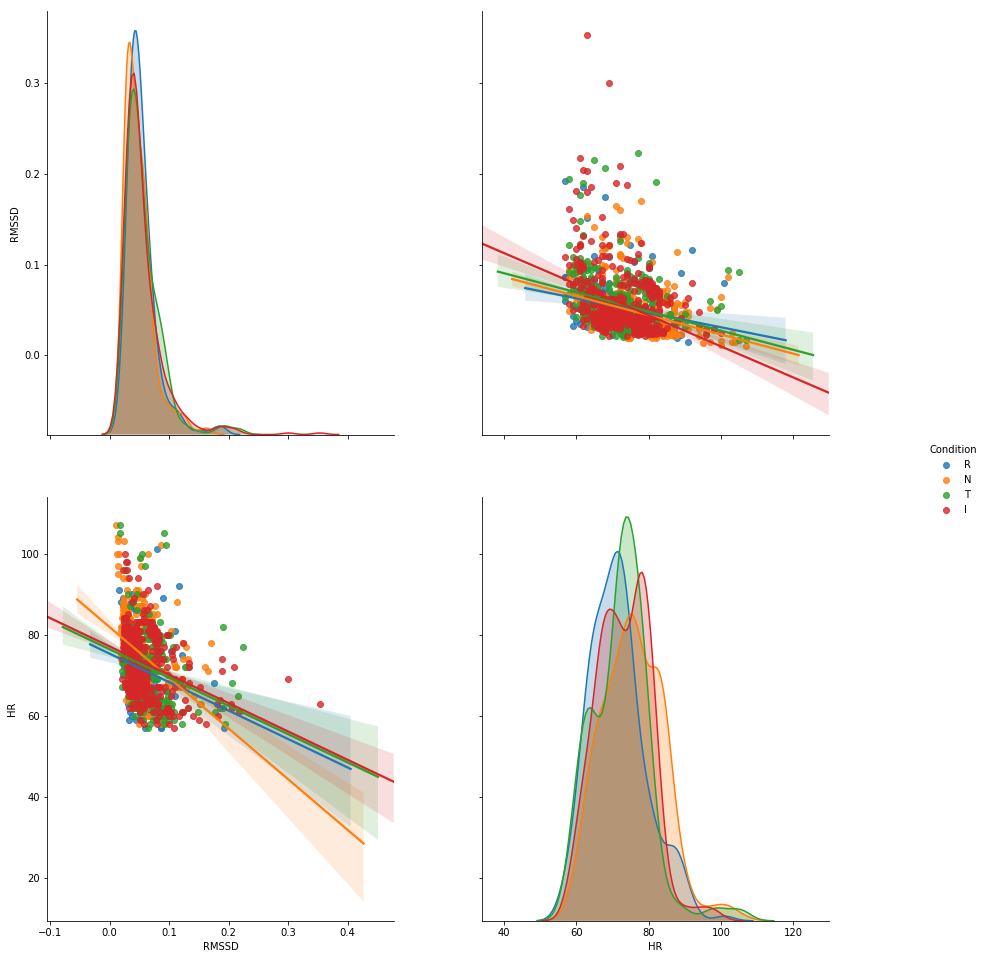

In [12]:
data_pairplot = data_df[['Condition','RMSSD','HR']].dropna()

g=sns.pairplot(data_pairplot, kind='reg', hue='Condition')
g.fig.set_size_inches(15,15)

plt.show()

## Analysis of RMSSD by Condition

The plot above shows all the distributions for each condition. In the below barplots we take the control, 'rest', and compare it against each condition. Again in each condition it looks like our data is skewed to the right.

It appears that the rest condition and each treatment have similar distributions and that the neutral condition show a lower average RMSSD than the other treatment states.

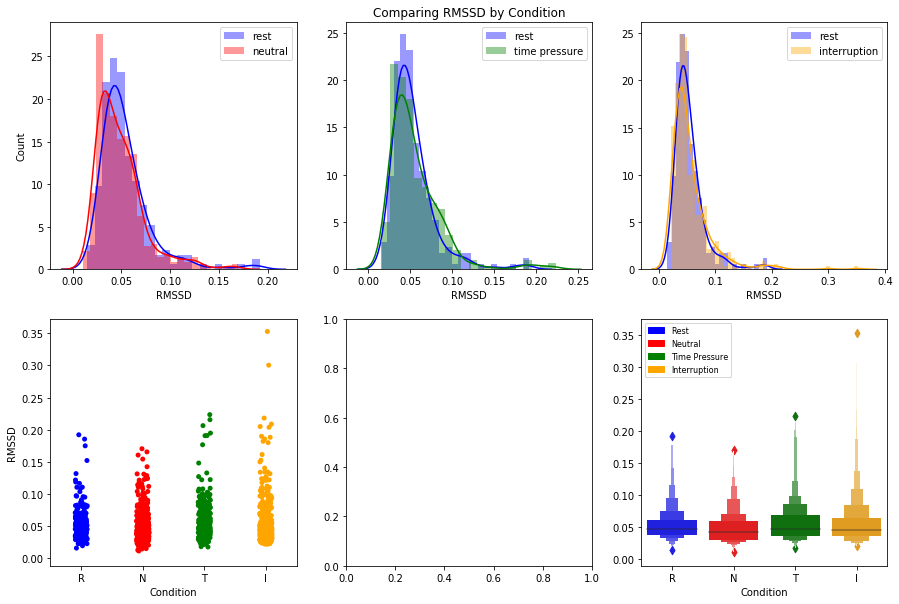

In [16]:
rest = data_df[data_df['Condition']=='R']
neutral = data_df[data_df['Condition']=='N']
time = data_df[data_df['Condition']=='T']
interrupt = data_df[data_df['Condition']=='I']

fig, axr = plt.subplots(nrows=2 ,ncols=3, figsize=(15,10))

sns.distplot(rest['RMSSD'].dropna(),color='blue',ax=axr[0,0],label='rest')
sns.distplot(neutral['RMSSD'].dropna(),color='red',ax=axr[0,0],label='neutral')

sns.distplot(rest['RMSSD'].dropna(),color='blue',ax=axr[0,1],label='rest')
sns.distplot(time['RMSSD'].dropna(),color='green',ax=axr[0,1],label='time pressure')

sns.distplot(rest['RMSSD'].dropna(),color='blue',ax=axr[0,2],label='rest')
sns.distplot(interrupt['RMSSD'].dropna(),color='orange',ax=axr[0,2],label='interruption')

clrs = ['blue','red','green','orange']

#sns.barplot(x=data_df['Condition'], y=data_df['RMSSD'], palette=clrs, ax=axr[1,0])
sns.stripplot(x=data_df['Condition'], y=data_df['RMSSD'], palette=clrs, ax=axr[1,0])
sns.boxenplot(x=data_df['Condition'], y=data_df['RMSSD'], palette=clrs, ax=axr[1,2],label=False)

axr[0][0].legend()
axr[0][1].legend()
axr[0][2].legend()

axr[0][0].set_ylabel('Count')
axr[1][1].set_ylabel('')
axr[1][2].set_ylabel('')
axr[0][1].set_title('Comparing RMSSD by Condition')

rest = mpatches.Patch(color='blue', label='Rest')
neutral = mpatches.Patch(color='red', label='Neutral')
time_pressure = mpatches.Patch(color='green', label='Time Pressure')
interruption = mpatches.Patch(color='orange', label='Interruption')

plt.legend(loc='upper left', prop={'size': 8}, handles=[rest,neutral,time_pressure,interruption])

plt.show()

## By Subject Scatter

Next we look at how each condition differed for each particpant. To accomplish this we will put all the RMSSD means on a scatter plot by condition. 

In [14]:
#collect study means
#by particpant/hue=condition, y axis = rMSSD

SUBJECTS = data.sheet_names
CONDITIONS = data_df.Condition.unique()

def calculate_mean_rmssd(condition,subject):
    return data_df[(data_df.Condition==condition) & (data_df.subject==subject)].RMSSD.mean()

#def calculate_mean_hr(condition,subject):
    #return data_df[(data_df.Condition==condition) & (data_df.subject==subject)].HR.mean()

def generate_means(conditions,subjects):
    output={}
    
    for subject in subjects:
        m = tuple(calculate_mean_rmssd(condition,subject) for condition in conditions)
        output[subject] = m
    
    return output

def generate_scatter(value,value_range):
    [plt.scatter(SUBJECTS, [elem[i] for elem in value.values()]) for i in range(value_range)]
    plt.show()
    

In [15]:
rmssd_means = generate_means(CONDITIONS,SUBJECTS)

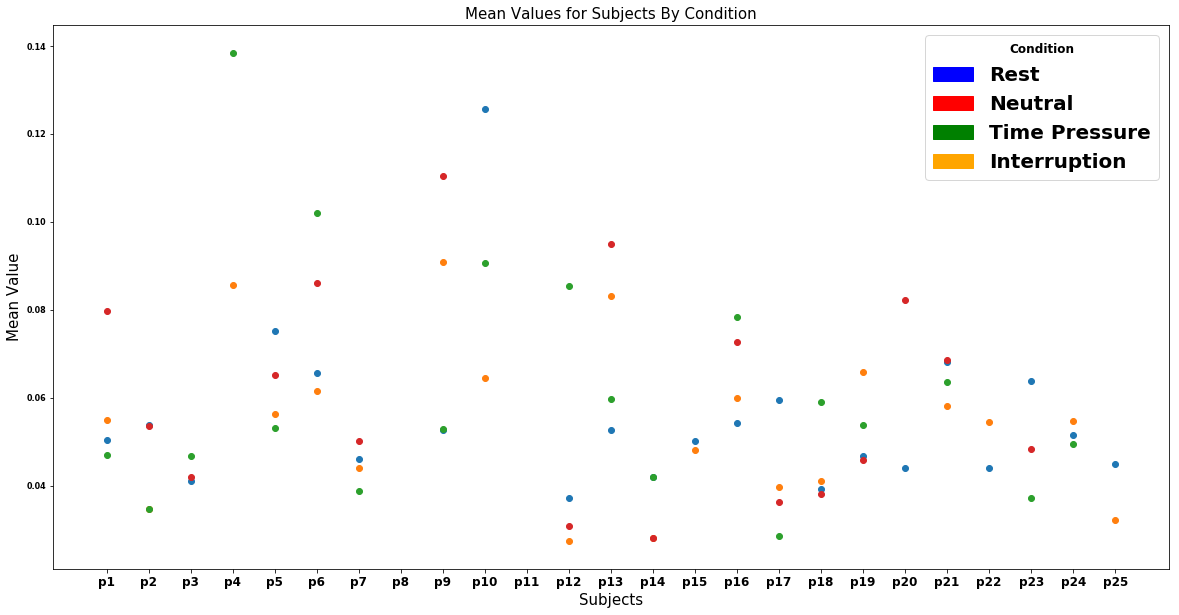

In [199]:
fig, axr = plt.subplots(figsize=(20,10))

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)             # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

axr.set_ylabel('Mean Value')
axr.set_xlabel('Subjects')
axr.set_title('Mean Values for Subjects By Condition')

rest = mpatches.Patch(color='blue', label='Rest')
neutral = mpatches.Patch(color='red', label='Neutral')
time_pressure = mpatches.Patch(color='green', label='Time Pressure')
interruption = mpatches.Patch(color='orange', label='Interruption')

plt.legend(title='Condition', loc='upper right', prop={'size': 20}, handles=[rest,neutral,time_pressure,interruption])

generate_scatter(rmssd_means,4)

# RMSSD Ranges By Subject

Continuing with the theme of analyzing the data per particpant below we can see box plots of each particpant's RMSSD values by condition.

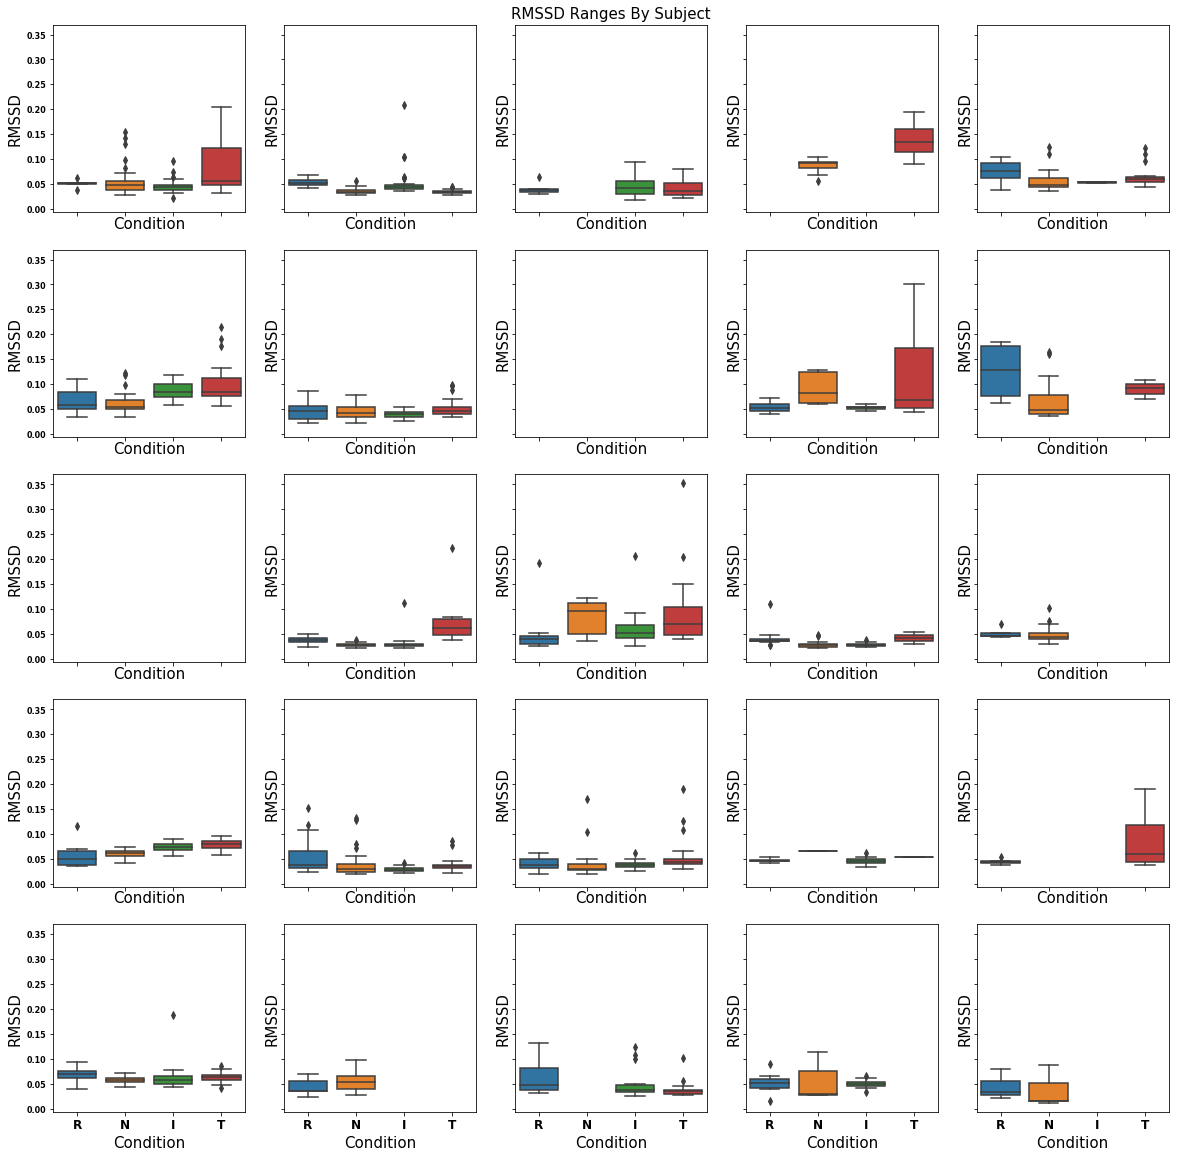

In [209]:
fig, axs = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(20,20))

rows = 5
columns = 5

temp_list = [0,5,10,15,20]

for x in range(rows):
    for y in range(columns):
        value = temp_list[x] + y
        DATA=data_df[data_df['subject']==list(rmssd_means.keys())[value]]
        sns.boxplot(x='Condition',y='RMSSD',data=DATA,ax=axs[x,y])

axs[0][2].set_title('RMSSD Ranges By Subject')
plt.show()

# Subject ttest

Finally we perform the t-test to determine if the difference in means is statistically signficant. You can see below that the only group that we can reject the null hypothesis is the neutral group.

In [36]:
rest_rmssd_all = data_df[data_df['Condition']=='R'].RMSSD
neutral_rmssd_all = data_df[data_df['Condition']=='N'].RMSSD
time_rmssd_all = data_df[data_df['Condition']=='T'].RMSSD
interrupt_rmssd_all = data_df[data_df['Condition']=='I'].RMSSD

In [74]:
#compare rest v. neutral
stat, p = ttest_ind(rest_rmssd_all.dropna(), neutral_rmssd_all.dropna())
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
    print(rest_rmssd_all.dropna().mean())
else:
    print('Different distribution (reject H0)')

Statistics=2.439, p=0.015
Different distribution (reject H0)


In [63]:
#compare rest v. time
stat, p = ttest_ind(rest_rmssd_all.dropna(), time_rmssd_all.dropna())
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=-1.033, p=0.302
Same distribution (fail to reject H0)


In [64]:
#compare rest v. time
stat, p = ttest_ind(rest_rmssd_all.dropna(), interrupt_rmssd_all.dropna())
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=-0.825, p=0.409
Same distribution (fail to reject H0)


## Log Transformation


In [75]:
rest_rmssd_log = rest_rmssd_all.apply(np.log)
neutral_rmssd_log = neutral_rmssd_all.apply(np.log)
time_rmssd_log = time_rmssd_all.apply(np.log)
interrupt_rmssd_log = interrupt_rmssd_all.apply(np.log)

In [81]:
#compare rest v. neutral
stat, p = ttest_ind(rest_rmssd_log.dropna(), neutral_rmssd_log.dropna())
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=3.274, p=0.001
Different distribution (reject H0)


In [78]:
stat, p = ttest_ind(rest_rmssd_log.dropna(), time_rmssd_log.dropna())
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=-0.564, p=0.573
Same distribution (fail to reject H0)


In [80]:
stat, p = ttest_ind(rest_rmssd_log.dropna(), interrupt_rmssd_log.dropna())
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=0.130, p=0.896
Same distribution (fail to reject H0)


## Research Proposal

Does chronic stress decrease Heart Rate Variability? 

We are interested in if workplace distractions decrease Heart Rate Variability as measured by RMSSD. Overall employee health could possibly lead to better decision making and thus increase value to the company. Tracking RMSSD may lead to a method of quantifying workplace stress and thus provide companies a method evaluating workplace environment and culture's impact on employee's physiological readiness. Previously we have studied the effect of mental stress on the subject in a 3-hour window. The next research proposal aims to study the effect of distractions over the course of a workweek. 

The proposed hypothesis would be that we believe that increased distraction will trying to complete assigned work will lead to an overall decrease in heart rate variability as measured by mean RMSSD over the course of a work week. Therefore the null hypothesis is that distraction and rest periods will produce the same mean RMSSD.

The participants in the study will be assigned a task for which they will have to write a report on that task and present their report at the end of the testing period. Overall the study will be conducted over five days and each day will consist of a three hour block where the participants will be measured. Participants will be randomly assigned to the control group or the treatment group. The control group will be told they can complete the assigned task within the time period alloted. In addition to completing the assigned task, the treatment group will be told they need to respond to emails immediately to emails sent during their measurment period. 

The study will be measuring heart rate variability by means of the root mean square of successive differences (RMSSD) using a chest strap heart rate monitor. RMSSD will be taken every minute by monitoring the heart rate continuously and returning the average RMSSD from that period. Data from each group will therefore consist of average RMSSD's taken every minutes during a three hour period for five successive days. 

The baseline change in RMSSD is 5% and we will be looking for a 12% change which means we will need 21,000 samples to achieve this. Using 25 participants who each provide 180 samples/day for five days will give us 22,500 samples. 